In [4]:
import torch
from models import *
from torch import nn
from torch import optim
import time

mini_batch_size = 100
nb_epochs = 25

def train_model(model, train_input, train_target, train_classes, mini_batch_size, aux_loss=False, opt="SGD", loss_func="CrossEntropy"):
    # Select loss function
    if (loss_func == "CrossEntropy"):
        criterion = nn.CrossEntropyLoss()

    # Select optimizer
    if (opt == "SGD"):
        optimizer = optim.SGD(model.parameters(), lr = 1e-1)
    if (opt == "Adam"):
        optimizer = optim.Adam(model.parameters(), lr = 0.015)
        
    log_losses = []

    for e in range(nb_epochs):
        # We do this with mini-batches
        mean_losses = 0
        for b in range(0, train_input.size(0), mini_batch_size):

            # if we want auxiliary loss
            if aux_loss:
                img1, img2, biggest = model(train_input.narrow(0, b, mini_batch_size))

                loss1 = criterion(img1, train_classes.narrow(0, b, mini_batch_size).narrow(1,0,1).view(-1))
                loss2 = criterion(img2, train_classes.narrow(0, b, mini_batch_size).narrow(1,1,1).view(-1))
                loss3 = criterion(biggest, train_target.narrow(0, b, mini_batch_size))

                #add loss1 and loss2 as auxiliary losses
                loss = loss1 + loss2 + loss3
                mean_losses += loss.mean().item()
            else:
                output = model(train_input.narrow(0, b, mini_batch_size))
                loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
                mean_losses += loss.mean().item()

            model.zero_grad()
            loss.backward()
            optimizer.step()
            
        log_losses.append(mean_losses)
        
    return log_losses

In [2]:
from utils import generate_pair_sets

mini_batch_size = 100
nb_epochs = 25

def compute_nb_errors(model, input, target, mini_batch_size, with_auxiliary_loss):
    count = 0
    for b in range(0, train_input.size(0), mini_batch_size):
        if (with_auxiliary_loss == False) :
            output = model(input.narrow(0, b, mini_batch_size))
        else :
            _, _, output = model(input.narrow(0, b, mini_batch_size))

        _, predicted_classes = output.max(1)
        for k in range(mini_batch_size):
            if target[b + k] != predicted_classes[k]:
                count = count + 1
    return count

train_input, train_target, train_classes, test_input, \
test_target, test_classes = generate_pair_sets(1000)

In [5]:
for i in range(10):
    aux_loss = True
    model = SIAMESE_CNN_AUX(act = "leaky")
    start_time = time.time()
    train_model(model, train_input, train_target, train_classes, mini_batch_size, aux_loss, opt = "Adam")
    print("training time: " + str(time.time() - start_time))
    n = compute_nb_errors(model, test_input, test_target, mini_batch_size, aux_loss)
    print("iteration: "+ str(i) + " nb errors: " + str(n)) 

C:\Users\omidk\anaconda3\lib\site-packages\torch\autograd\__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


training time: 19.320571899414062
iteration: 0 nb errors: 83


KeyboardInterrupt: 

In [16]:
import copy

def run_model(model, aux_loss, opt, nbr_runs):
    losses = []
    
    for i in range(nbr_runs):
        # Generate data at eah iteration
        train_input, train_target, train_classes, test_input, \
        test_target, test_classes = generate_pair_sets(1000)
        
        temp_model = copy.deepcopy(model)
        start_time = time.time()
        log_losses = train_model(temp_model, train_input, train_target, train_classes, mini_batch_size, aux_loss, opt=opt)
        print("Training time: " + str(time.time() - start_time))
        n = compute_nb_errors(temp_model, test_input, test_target, mini_batch_size, aux_loss)
        print("Iteration: "+ str(i + 1) + ", Test errors: " + str(n) + "Test error rate: " + str((n * 100 / n)) + "%")
        losses.append(log_losses)
    return losses

In [17]:
def plot_losses(list_losses):
    for i in range(len(list_losses)):
        plt.plot(list_losses[i])
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

In [18]:
# DEFINE MODELS TO TEST

model = SIAMESE_CNN_AUX(act = "leaky")
losses = run_model(model, aux_loss=True, opt="SGD", nbr_runs=10)

Training time: 17.723853588104248
Iteration: 1, Test errors: 100Test error rate: 100.0%
Training time: 13.78872561454773
Iteration: 2, Test errors: 121Test error rate: 100.0%
Training time: 14.362809181213379
Iteration: 3, Test errors: 102Test error rate: 100.0%
Training time: 14.378765344619751
Iteration: 4, Test errors: 121Test error rate: 100.0%
Training time: 14.74277114868164
Iteration: 5, Test errors: 102Test error rate: 100.0%
Training time: 11.794493675231934
Iteration: 6, Test errors: 110Test error rate: 100.0%
Training time: 9.136948585510254
Iteration: 7, Test errors: 98Test error rate: 100.0%
Training time: 7.519395589828491
Iteration: 8, Test errors: 122Test error rate: 100.0%
Training time: 9.12106966972351
Iteration: 9, Test errors: 122Test error rate: 100.0%
Training time: 7.976792097091675
Iteration: 10, Test errors: 91Test error rate: 100.0%


No handles with labels found to put in legend.


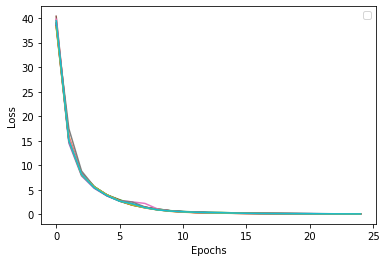

In [19]:
import matplotlib.pyplot as plt
list_losses = losses
list_labels = ["ReLU", "Tanh"]
plot_losses(list_losses)

## PROBLEM